In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [18]:
# чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

# Baseline Prophet

In [19]:
# обучение модели baseline prophet
bl_prophet = Prophet()
bl_prophet.fit(df_train)

02:12:58 - cmdstanpy - INFO - Chain [1] start processing
02:12:58 - cmdstanpy - INFO - Chain [1] done processing


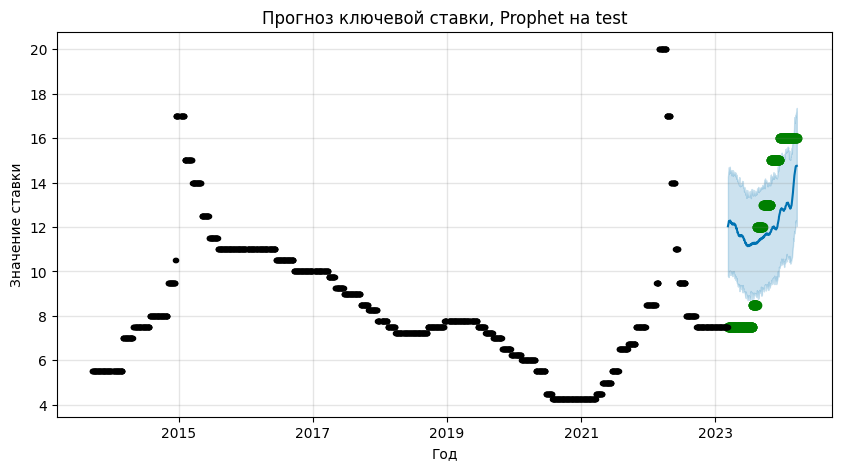

In [20]:
# смотрим совпадение фактического курса с предсказанным курсом baseline prophet
fig, ax = plt.subplots(figsize= (10, 5))

predict = bl_prophet.predict(df_test)
fig = bl_prophet.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

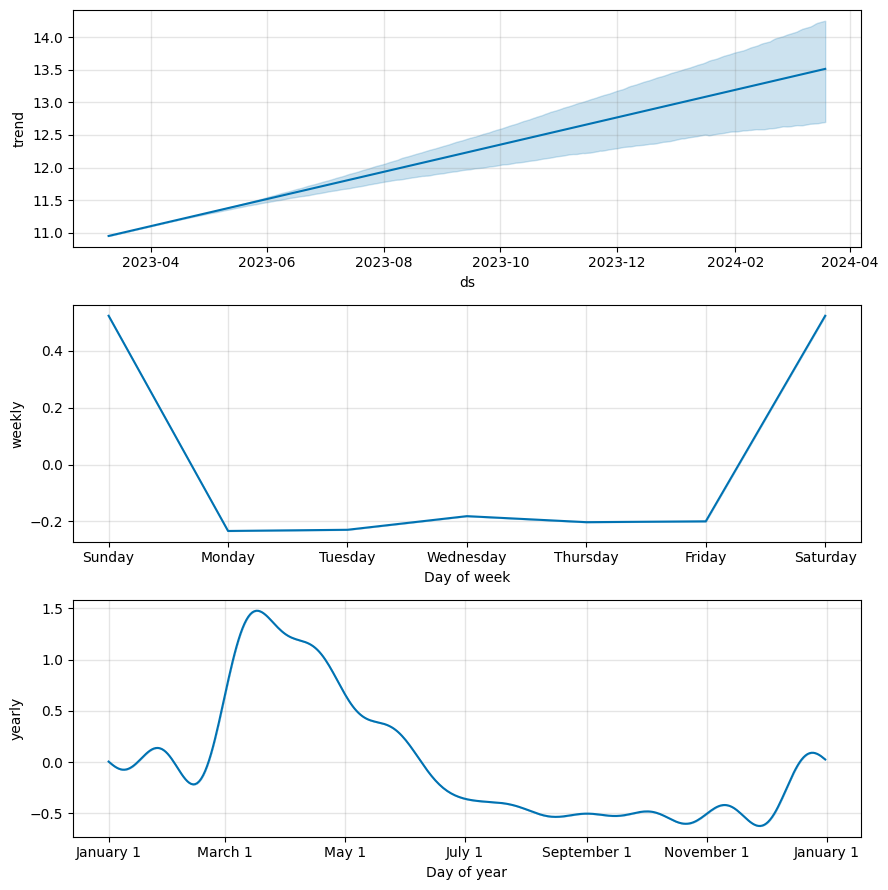

In [21]:
# смотрим тренд, годовые и сезонные признаки
fig = bl_prophet.plot_components(predict)
plt.show()

In [22]:
# выводиим метрики для оценкии baseline prophet 
metrics = get_metrics(y_test=df_test['y'], y_pred=predict['yhat'], name='Baseline Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Baseline Prophet,2.930196,0.302887,10.103171,3.178549


1. Mean Absolute Error (MAE) - Среднее абсолютное отклонение позволяет оценить среднее абсолютное отклонение прогнозов от фактических значений. Чем ниже MAE, тем лучше модель.
2. Mean Absolute Percentage Error (MAPE) - Среднее абсолютное процентное отклонение показывает средний процент ошибки прогноза от фактических значений. Чем ниже MAPE, тем лучше.
3. Mean Squared Error (MSE) - Среднеквадратичное отклонение предоставляет информацию о среднеквадратичном отклонении прогнозов от фактических значений. Чем ниже MSE, тем лучше модель.
4. Root Mean Squared Error (RMSE) - Квадратный корень из MSE помогает интерпретировать стандартное отклонение прогнозов от фактических значений.

# Tuning Prophet

## Cross validation

In [23]:
fix_percent = int(df.shape[0]*0.1)

In [24]:
# Осуществить кросс-валидацию
df_cv = cross_validation(bl_prophet, initial='730 days', period='90 days', horizon='365 days')

# Рассчитать метрики производительности
df_metrics = performance_metrics(df_cv)

  0%|          | 0/27 [00:00<?, ?it/s]

02:13:00 - cmdstanpy - INFO - Chain [1] start processing
02:13:00 - cmdstanpy - INFO - Chain [1] done processing
02:13:00 - cmdstanpy - INFO - Chain [1] start processing
02:13:01 - cmdstanpy - INFO - Chain [1] done processing
02:13:01 - cmdstanpy - INFO - Chain [1] start processing
02:13:01 - cmdstanpy - INFO - Chain [1] done processing
02:13:02 - cmdstanpy - INFO - Chain [1] start processing
02:13:02 - cmdstanpy - INFO - Chain [1] done processing
02:13:02 - cmdstanpy - INFO - Chain [1] start processing
02:13:02 - cmdstanpy - INFO - Chain [1] done processing
02:13:03 - cmdstanpy - INFO - Chain [1] start processing
02:13:03 - cmdstanpy - INFO - Chain [1] done processing
02:13:03 - cmdstanpy - INFO - Chain [1] start processing
02:13:04 - cmdstanpy - INFO - Chain [1] done processing
02:13:04 - cmdstanpy - INFO - Chain [1] start processing
02:13:04 - cmdstanpy - INFO - Chain [1] done processing
02:13:05 - cmdstanpy - INFO - Chain [1] start processing
02:13:05 - cmdstanpy - INFO - Chain [1]

In [25]:
# выводиим метрики для оценкии tuning prophet 
metrics = pd.concat([metrics, get_metrics(y_test=df_cv['y'], y_pred=df_cv['yhat'], name='CV Prophet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Baseline Prophet,2.930196,0.302887,10.103171,3.178549
0,CV Prophet,2.025378,0.246632,10.518599,3.243239
